In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Conv1D,Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

In [3]:
df = pd.read_csv('energy.csv')

In [4]:
df.head()

,TOTAL_FLOOR_AREA,NUMBER_HEATED_ROOMS,CURRENT_ENERGY_EFFICIENCY,energy
0,54,3.0,52,313
1,47,2.0,67,231
2,97,4.0,72,170
3,95,3.0,67,199
4,44,2.0,73,197


In [10]:
data.isnull().sum()


TOTAL_FLOOR_AREA             0
NUMBER_HEATED_ROOMS          0
CURRENT_ENERGY_EFFICIENCY    0
energy                       0
dtype: int64

In [9]:
data = df.dropna()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4114 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TOTAL_FLOOR_AREA           4114 non-null   int64  
 1   NUMBER_HEATED_ROOMS        4114 non-null   float64
 2   CURRENT_ENERGY_EFFICIENCY  4114 non-null   int64  
 3   energy                     4114 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 160.7 KB


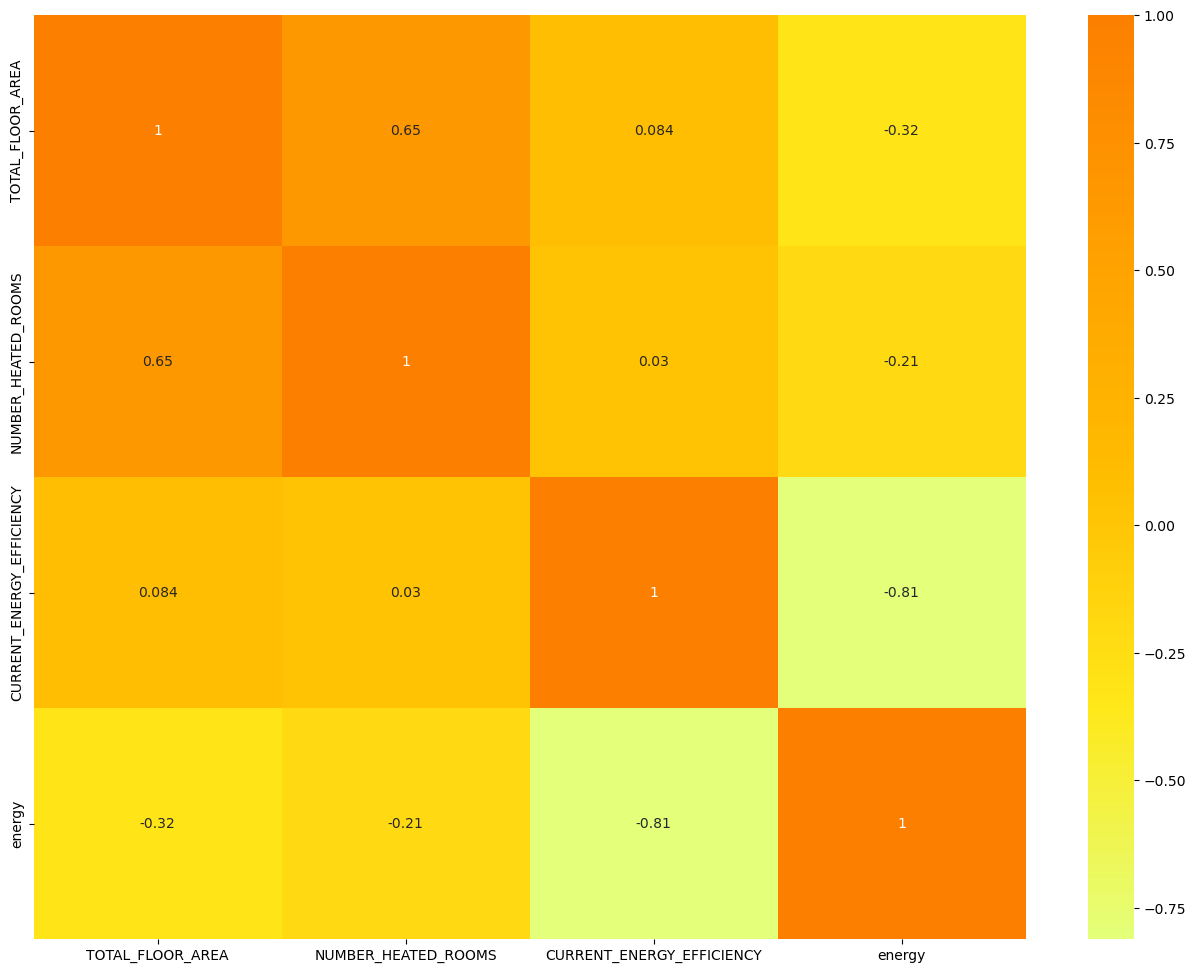

In [14]:
fig= plt.subplots(figsize=(16,12))
corr = data.corr()
sns.heatmap(corr, cmap = 'Wistia', annot = True)
plt.show()

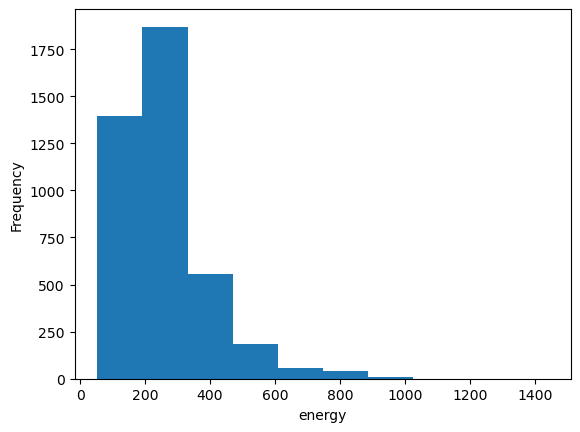

In [15]:
plt.hist(data["energy"])
plt.xlabel("energy")
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Missing Value in Dataset')

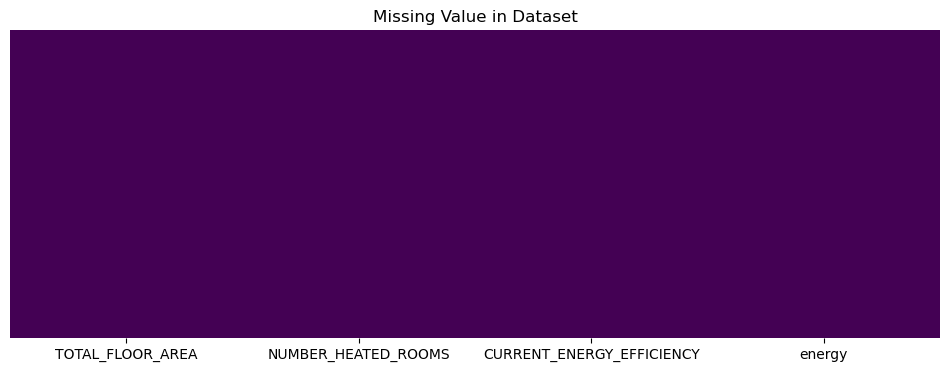

In [18]:
plt.figure(figsize = (12,4))
sns.heatmap(data.isnull(), cbar = False, cmap = 'viridis', yticklabels = False)
plt.title('Missing Value in Dataset')

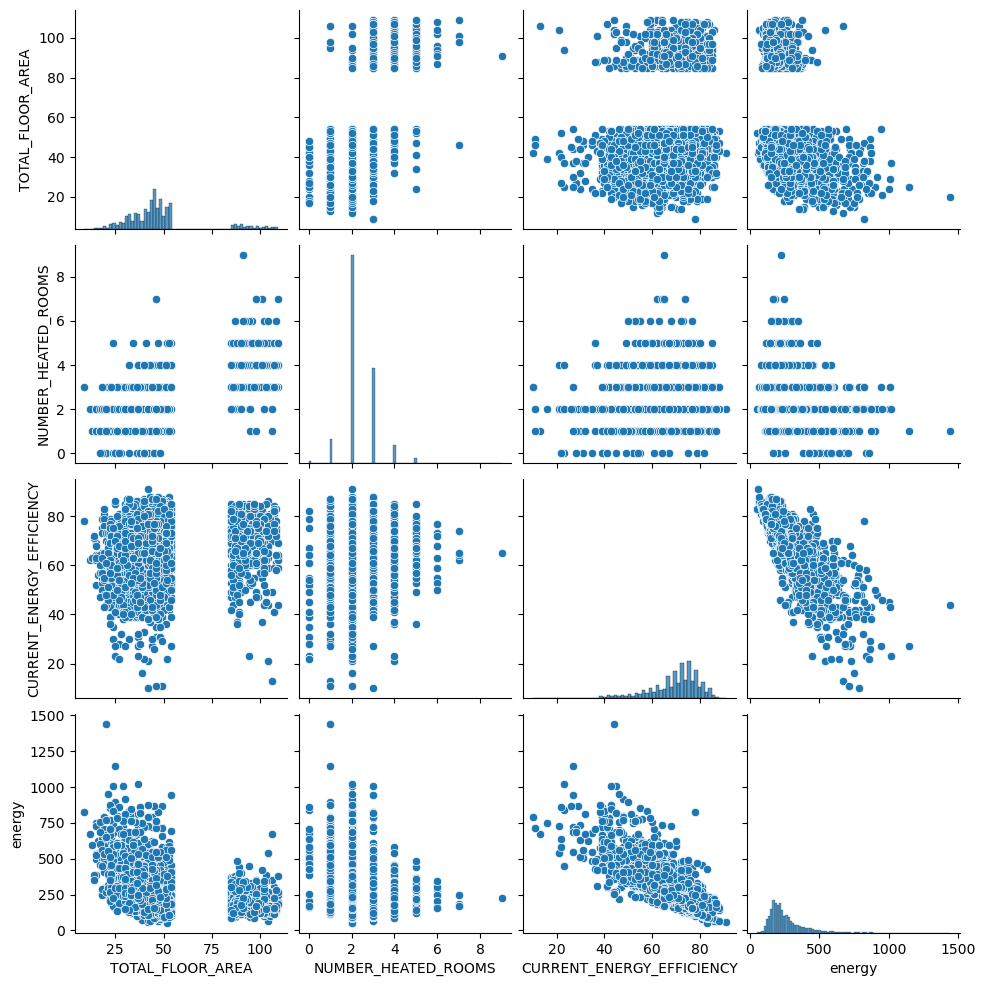

In [21]:
sns.pairplot(data)

In [67]:
def create_dataset(data, scaler, window_size=3):
    X, y = [], []
    for i in range(0, data.shape[0]-window_size):
        X.append(data[i:i + window_size, :])
        y.append(data[i + window_size, -1])
    X, y = np.array(X), np.array(y)
    y = np.reshape(y, (len(y), 1))

    #X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)
    #X = np.stack([X0, X1, X2, X3, X4, X5], axis=2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [68]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)
X_train, y_train, X_val, y_val, X_test, y_test = create_dataset(data_scaled, scaler, window_size=3)

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 4))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 4))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 4))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2877, 3, 4)
(617, 3, 4)
(617, 3, 4)


In [63]:
def prepare_dataset(data, size):
  x_data = []
  y_data = []

  l = len(data) - size

  for i in range(l):
    x = data[i:i+size]
    y = data[i+size]
    x_data.append(x)
    y_data.append(y)

  return np.array(x_data), np.array(y_data)

In [64]:
data_filtered = df['energy'].values

scaler = MinMaxScaler(feature_range = (0,1))

scaled_data = scaler.fit_transform(data_filtered.reshape(-1,1))
scaled_data.shape

(5000, 1)

In [65]:
train_size = int(np.ceil(len(scaled_data) * 0.8))
test_size = int((len(scaled_data) - train_size) *0.5)
print(train_size, test_size)

4000 500


In [60]:
xtrain, ytrain = prepare_dataset(scaled_data[:train_size], 30)
xval, yval = prepare_dataset(scaled_data[train_size-2:train_size +test_size], 30)
xtest, ytest = prepare_dataset(scaled_data[train_size + test_size-2:],30)

In [71]:
print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

(3970, 30, 1)
(472, 30, 1)
(472, 30, 1)


In [69]:
from keras.optimizers import adam_v2
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
optimizer = adam_v2.Adam(learning_rate=0.001)
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)]

#optimizer = adam_v2.Adam(learning_rate=lr, decay=lr/epochs)

In [70]:
def plot_model_rmse_and_loss(history, title):
    # Evaluate train and validation RMSE and Loss
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation RMSE and Loss
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(train_rmse, label='Training RMSE')
    axs[0].plot(val_rmse, label='Validation RMSE')
    axs[0].legend()
    axs[0].set_title('Epochs vs. Training and Validation RMSE')
    axs[0].text(0.6, 0.9, 'Monocrystalline', horizontalalignment='left', verticalalignment='top', transform=axs[0].transAxes, fontsize = 12,
                 bbox = dict(facecolor = 'g', alpha = 0.5))
    axs[1].plot(train_loss, label='Training Loss')
    axs[1].plot(val_loss, label='Validation Loss')
    axs[1].legend()
    axs[1].set_title('Epochs vs. Training and Validation Loss')
    axs[1].text(0.6, 0.9, 'Monocrystalline', horizontalalignment='left', verticalalignment='top', transform=axs[1].transAxes, fontsize = 12,
                 bbox = dict(facecolor = 'g', alpha = 0.5))
    fig.suptitle(title, fontweight = 'bold',  fontsize= 15)
    plt.show()


In [71]:
model_RNN_LSTM = Sequential()
model_RNN_LSTM.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model_RNN_LSTM.add(SimpleRNN(64, return_sequences=True))
model_RNN_LSTM.add(LSTM(64, return_sequences = True, activation = 'relu'))
model_RNN_LSTM.add(Flatten())
model_RNN_LSTM.add(Dropout(0.2))
model_RNN_LSTM.add(Dense(1))
model_RNN_LSTM.compile(loss = 'mse', metrics = metric)

model_RNN_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 128)            68096     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 3, 64)             12352     
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
flatten_4 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 193       
Total params: 113,665
Trainable params: 113,665
Non-trainable params: 0
________________________________________________

In [72]:
history=model_RNN_LSTM.fit(X_train, y_train, epochs=100,  validation_data=(X_val, y_val), verbose=0, batch_size=64, callbacks=early_stopping)

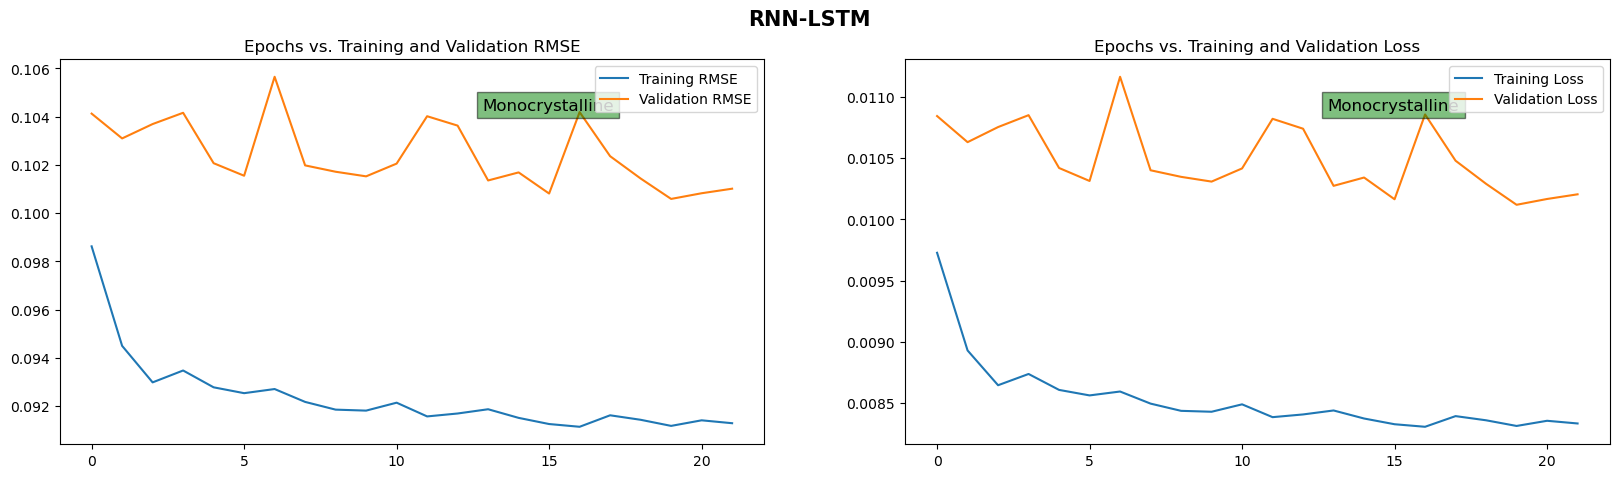

In [73]:
plot_model_rmse_and_loss(history,"RNN-LSTM")

In [74]:
RNN_LSTM_Predict = model_RNN_LSTM.predict(X_test)
predictions_RNN = scaler.inverse_transform(RNN_LSTM_Predict)
y_test_inverse= scaler.inverse_transform(y_test)

RNN_rmse = np.sqrt(mean_squared_error(predictions_RNN, y_test_inverse))
RNN_mae= (mean_absolute_error(predictions_RNN, y_test_inverse))
RNN_mse= (mean_squared_error(predictions_RNN, y_test_inverse))
RNN_r1= (r2_score(predictions_RNN, y_test_inverse))

print(f"\n Root Mean Squarred Error for RNN-LSTM = {RNN_rmse}")
print(f"\n Mean Squarred Error for RNN-LSTM = {RNN_mse}")
print(f"\n Mean Absolute Error for RNN-LSTM = {RNN_mae}")
print(f"\n R Square Error for RNN-LSTM =  {RNN_r1}")


 Root Mean Squarred Error for RNN-LSTM = 0.09479565255583663

 Mean Squarred Error for RNN-LSTM = 0.008986215743486896

 Mean Absolute Error for RNN-LSTM = 0.0674904859425031

 R Square Error for RNN-LSTM =  -91.22388736908009


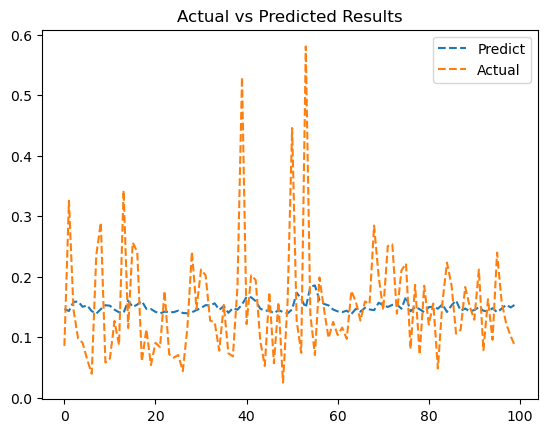

In [81]:
plt.plot(predictions_RNN[:100], '--', label='Predict')
plt.plot(y_test_inverse[:100], '--', label='Actual')
plt.title('Actual vs Predicted Results')
plt.legend()

In [52]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Flatten())
model.add(Dropout(0.2))

# add output layer
model.add(Dense(1))

# compile model
model.compile(loss='mse', optimizer=adam_v2.Adam(learning_rate=0.01), metrics = metric)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 7, 64)             320       
_________________________________________________________________
dense_33 (Dense)             (None, 7, 64)             4160      
_________________________________________________________________
dense_34 (Dense)             (None, 7, 64)             4160      
_________________________________________________________________
dense_35 (Dense)             (None, 7, 64)             4160      
_________________________________________________________________
dense_36 (Dense)             (None, 7, 64)             4160      
_________________________________________________________________
dense_37 (Dense)             (None, 7, 64)             4160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 448)              

In [59]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 8, epochs = 100, callbacks = early_stopping, verbose = 0)

In [61]:
Predict = model.predict(X_test)
predictions = scaler.inverse_transform(Predict)
y_inverse= scaler.inverse_transform(y_test)

RNN_rmse = np.sqrt(mean_squared_error(predictions, y_inverse))
RNN_mae= (mean_absolute_error(predictions, y_inverse))
RNN_mse= (mean_squared_error(predictions, y_inverse))
RNN_r1= (r2_score(predictions, y_inverse))

print(f"\n Root Mean Squarred Error for RNN-LSTM = {RNN_rmse}")
print(f"\n Mean Squarred Error for RNN-LSTM = {RNN_mse}")
print(f"\n Mean Absolute Error for RNN-LSTM = {RNN_mae}")
print(f"\n R Square Error for RNN-LSTM =  {RNN_r1}")


 Root Mean Squarred Error for RNN-LSTM = 0.09497139468380629

 Mean Squarred Error for RNN-LSTM = 0.00901956580818731

 Mean Absolute Error for RNN-LSTM = 0.06757588781054748

 R Square Error for RNN-LSTM =  0.0


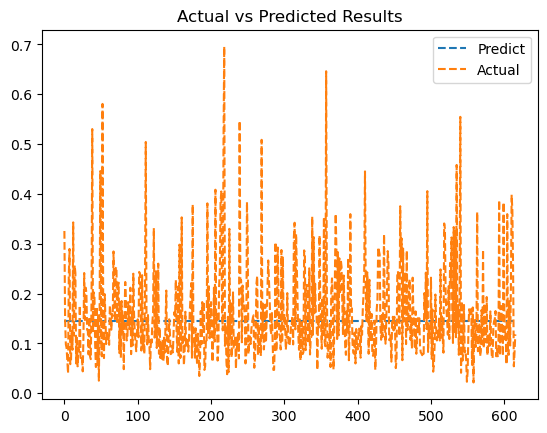

In [58]:
plt.plot(predictions, '--', label='Predict')
plt.plot(y_inverse, '--', label='Actual')
plt.title('Actual vs Predicted Results')
plt.legend()

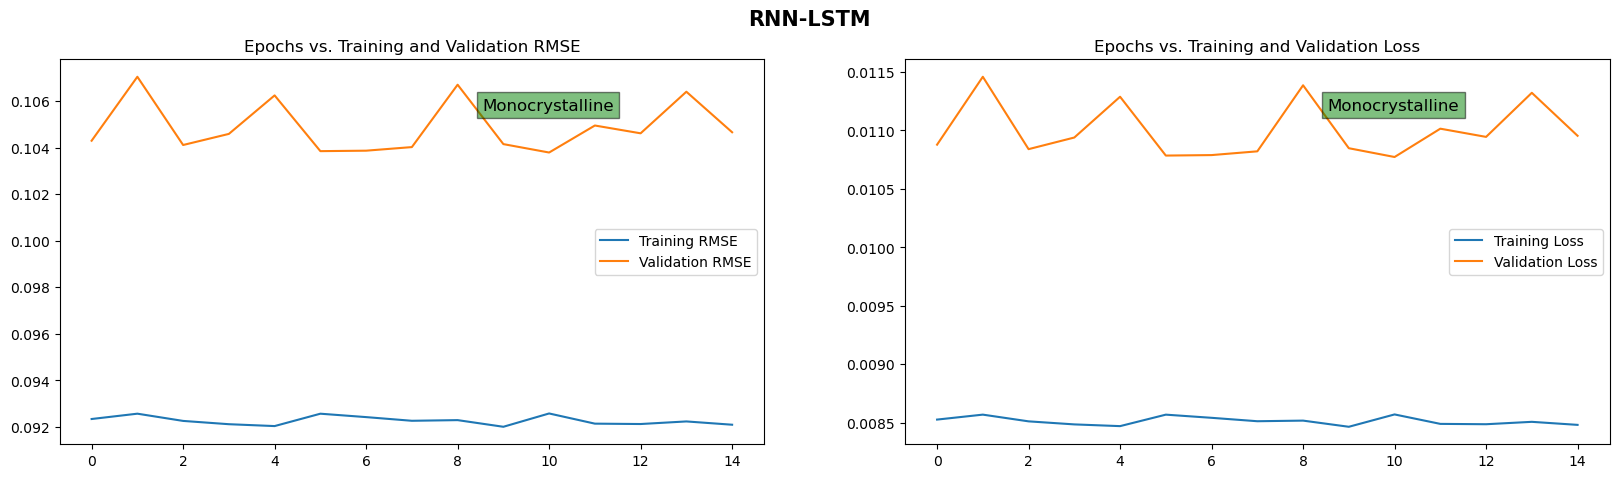

In [57]:
plot_model_rmse_and_loss(history,"RNN-LSTM")